In [19]:
import numpy as np 
import pandas as pd
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import shutil
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt


In [4]:
import tensorflow as tf

# Use 'local' to indicate you're using the pre-provisioned TPU in Kaggle
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')

# Connect to the TPU
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# Set the TPU strategy
strategy = tf.distribute.TPUStrategy(resolver)

print("TPU initialized successfully!")


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1730191528.057175      13 service.cc:145] XLA service 0x5d187b8ed900 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730191528.057236      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730191528.057240      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730191528.057244      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730191528.057246      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730191528.057249      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730191528.057252      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730191528.057255      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730191528.057257      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
for dirname, subdirs, filenames in os.walk('/kaggle/input'):
    print(dirname)


/kaggle/input
/kaggle/input/paddy-disease
/kaggle/input/paddy-disease/tungro
/kaggle/input/paddy-disease/yellow_stem_borer
/kaggle/input/paddy-disease/hispa
/kaggle/input/paddy-disease/downy_mildew
/kaggle/input/paddy-disease/black_stem_borer
/kaggle/input/paddy-disease/bacterial_leaf_streak
/kaggle/input/paddy-disease/bacterial_leaf_blight
/kaggle/input/paddy-disease/brown_spot
/kaggle/input/paddy-disease/blast
/kaggle/input/paddy-disease/leaf_roller
/kaggle/input/paddy-disease/normal
/kaggle/input/paddy-disease/bacterial_panicle_blight
/kaggle/input/paddy-disease/white_stem_borer


In [13]:
input_dir = '/kaggle/input/paddy-disease'
output_dir = '/kaggle/working/extracted_images'
os.makedirs(output_dir, exist_ok=True)

for dirname, _, filenames in os.walk(input_dir):
    if filenames:  
        image_name = filenames[0]  
        image_path = os.path.join(dirname, image_name)
       
       
        subdir_name = os.path.basename(dirname)
         
        try:
            with Image.open(image_path) as img:
                output_image_path = os.path.join(output_dir, f"{subdir_name}.jpg")
                img.save(output_image_path, dpi=(300, 300)) 
                print(f"Saved: {output_image_path} with 300 DPI")
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")


shutil.make_archive('/kaggle/working/extracted_images', 'zip', output_dir)


Failed to process /kaggle/input/paddy-disease/metadata.csv: cannot identify image file '/kaggle/input/paddy-disease/metadata.csv'
Saved: /kaggle/working/extracted_images/tungro.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/yellow_stem_borer.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/hispa.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/downy_mildew.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/black_stem_borer.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/bacterial_leaf_streak.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/bacterial_leaf_blight.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/brown_spot.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/blast.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/leaf_roller.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/normal.jpg with 300 DPI
Saved: /kaggle/working/extracted_images/bacterial_panicle_blight.jpg with 300 DPI
Saved: /kaggle/worki

'/kaggle/working/extracted_images.zip'

In [6]:
import tensorflow as tf
import os
import numpy as np

# Directory paths
input_dir = '/kaggle/input/paddy-disease'
augmented_dir = '/kaggle/working/augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32  # Adjust as per memory capacity

# Load file paths and labels
class_names = sorted([subdir for subdir in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, subdir))])
class_labels = {name: idx for idx, name in enumerate(class_names)}
file_paths, labels = [], []
for class_name, label in class_labels.items():
    class_dir = os.path.join(input_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            file_paths.append(os.path.join(class_dir, filename))
            labels.append(label)

# Define functions for loading and augmenting images
def load_and_preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0  # Normalize to [0,1] range
    return img, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image, label

# Create dataset and apply augmentation
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Save augmented images
for batch_idx, (batch_images, batch_labels) in enumerate(dataset):
    for i in range(batch_images.shape[0]):
        image = tf.image.convert_image_dtype(batch_images[i], dtype=tf.uint8)
        pil_image = tf.keras.preprocessing.image.array_to_img(image.numpy())
        
        # Determine label and save path
        label_name = class_names[batch_labels[i].numpy()]
        class_dir = os.path.join(augmented_dir, label_name)
        os.makedirs(class_dir, exist_ok=True)

        # Save with a unique name
        file_name = os.path.join(class_dir, f"augmented_{batch_idx * BATCH_SIZE + i}.jpg")
        pil_image.save(file_name)
        print(f"Saved: {file_name}")


Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_0.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_1.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_2.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_3.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_4.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_5.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_6.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_7.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_8.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_9.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_10.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/augmented_11.jpg
Saved: /kaggle/working/augmented_images/bacterial_leaf_blight/

In [7]:
import tensorflow as tf
import os
import numpy as np
import shutil  # Importing shutil

input_dir = '/kaggle/input/paddy-disease'
augmented_dir = '/kaggle/working/augmented_images'
os.makedirs(augmented_dir, exist_ok=True)


# Create a ZIP file of the augmented images using shutil
zip_file_path = '/kaggle/working/augmented_images.zip'
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', augmented_dir)

print(f"Zipped augmented images to: {zip_file_path}")

Zipped augmented images to: /kaggle/working/augmented_images.zip


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define paths
augmented_dir = '/kaggle/input/paddy-augmented' 
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

# Create an ImageDataGenerator for loading the augmented dataset
datagen = ImageDataGenerator(rescale=1./255)  # Normalize images

# Create a generator
generator = datagen.flow_from_directory(
    augmented_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels needed for feature extraction
    shuffle=False, 
)

# Load the pre-trained ResNet50 model without the classification layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features manually in batches
features_list = []
try:
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        # Get the next batch of images using next()
        x_batch = next(generator)
        # Extract features
        batch_features = base_model.predict(x_batch, verbose=1)
        features_list.append(batch_features)
except Exception as e:
    print(f"Error during feature extraction: {e}")

# Convert the list of features to a NumPy array
if features_list:
    features = np.concatenate(features_list, axis=0)
    # Save features to a file
    np.save('extracted_features.npy', features)
else:
    print("No features were extracted.")

# Optionally, save labels for later use
labels = generator.classes
np.save('extracted_labels.npy', labels)

print(f'Extracted features shape: {features.shape}' if 'features' in locals() else "Features variable not defined.")


Found 16225 images belonging to 13 classes.
Error during feature extraction: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/si

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define paths
augmented_dir = '/kaggle/input/paddy-augmented' 
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

# Create an ImageDataGenerator for loading the augmented dataset
datagen = ImageDataGenerator(rescale=1./255)  # Normalize images

# Create a generator
generator = datagen.flow_from_directory(
    augmented_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels needed for feature extraction
    shuffle=False, 
)

# Load the pre-trained ResNet50 model without the classification layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features manually in batches
features_list = []
try:
    # Create a function to predict features
    def extract_features(generator):
        for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
            x_batch = next(generator)
            batch_features = base_model(x_batch, training=False)  # Call the model directly
            features_list.append(batch_features)

    # Call the feature extraction function
    extract_features(generator)

except tf.errors.InvalidArgumentError as e:
    print(f"Invalid argument error during feature extraction: {e}")
except Exception as e:
    print(f"Error during feature extraction: {e}")

# Convert the list of features to a NumPy array
if features_list:
    features = np.concatenate(features_list, axis=0)
    # Save features to a file
    np.save('extracted_features.npy', features)
else:
    print("No features were extracted.")

# Optionally, save labels for later use
labels = generator.classes
np.save('extracted_labels.npy', labels)

print(f'Extracted features shape: {features.shape}' if 'features' in locals() else "Features variable not defined.")


Found 16225 images belonging to 13 classes.
Extracted features shape: (16225, 2048)


In [17]:
import numpy as np
import pandas as pd

# Load the extracted features
features = np.load('extracted_features.npy')

# Load the extracted labels (if you saved them)
labels = np.load('extracted_labels.npy')

# Convert features to a DataFrame
features_df = pd.DataFrame(features)

# Convert labels to a DataFrame (optional)
labels_df = pd.DataFrame(labels, columns=['Label'])

# Display the first few rows of the features DataFrame
print("Features DataFrame:")
print(features_df.head())

# Display the first few rows of the labels DataFrame (if applicable)
print("\nLabels DataFrame:")
print(labels_df.head())


Features DataFrame:
   0     1         2     3         4     5     6         7         8     9     \
0   0.0   0.0  0.012648   0.0  1.206893   0.0   0.0  0.699943  0.011422   0.0   
1   0.0   0.0  0.003217   0.0  1.198624   0.0   0.0  0.964200  0.006133   0.0   
2   0.0   0.0  0.000000   0.0  0.991761   0.0   0.0  0.344509  0.012030   0.0   
3   0.0   0.0  0.001103   0.0  1.253188   0.0   0.0  0.707969  0.025776   0.0   
4   0.0   0.0  0.007272   0.0  1.362954   0.0   0.0  0.843763  0.015774   0.0   

   ...  2038  2039  2040  2041      2042  2043  2044      2045  2046  2047  
0  ...   0.0   0.0   0.0   0.0  0.004536   0.0   0.0  2.325724   0.0   0.0  
1  ...   0.0   0.0   0.0   0.0  0.025460   0.0   0.0  1.627311   0.0   0.0  
2  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  2.463979   0.0   0.0  
3  ...   0.0   0.0   0.0   0.0  0.000000   0.0   0.0  2.142914   0.0   0.0  
4  ...   0.0   0.0   0.0   0.0  0.022160   0.0   0.0  1.885562   0.0   0.0  

[5 rows x 2048 columns]

Label

In [18]:
!pip install scikit-learn



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
features = np.load('extracted_features.npy')
labels = np.load('extracted_labels.npy')

from sklearn.preprocessing import StandardScaler
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [22]:
# Apply PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
principal_components = pca.fit_transform(features_scaled)

# Create a DataFrame for the PCA result
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Label'] = labels


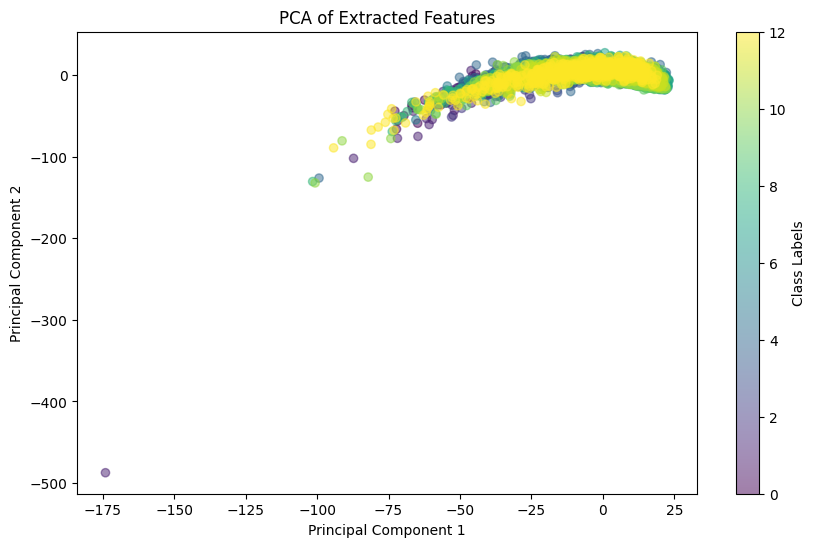

In [23]:
# Visualize PCA Results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], 
                      c=pca_df['Label'], cmap='viridis', alpha=0.5)
plt.title('PCA of Extracted Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Class Labels')

# Save the PCA plot
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()


In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA
lda = LDA(n_components=len(np.unique(labels)) - 1)  # Number of classes - 1
lda_result = lda.fit_transform(features_scaled, labels)

# Create a DataFrame for the LDA result
lda_df = pd.DataFrame(data=lda_result, columns=[f'LD{i+1}' for i in range(lda_result.shape[1])])  # Create columns dynamically based on components
lda_df['Label'] = labels

# Display the first few rows of the LDA DataFrame
print(lda_df.head())


        LD1       LD2       LD3       LD4       LD5       LD6       LD7  \
0  0.230327  0.053201  0.307761 -0.949510 -0.885073 -0.704875  2.014828   
1 -1.367876  0.924626 -0.281613  0.261775  0.404818  0.566126  0.594948   
2  0.182887  0.453001  0.496267 -1.649192 -0.842245  2.258302  1.642823   
3 -0.150720  0.933814  0.017122 -2.638364  0.365360  1.646314  0.564732   
4 -0.688497  1.331026 -0.172778 -0.665010  0.575674  0.132332 -0.404991   

        LD8       LD9      LD10      LD11      LD12  Label  
0  0.108453 -0.828559 -0.790782  1.260533 -1.025280      0  
1 -0.478967  0.155711 -1.030152  0.088296 -0.680808      0  
2 -2.257850  0.630072  0.085940  1.605920 -5.943072      0  
3  0.236628 -0.824275 -0.104264 -0.268123  0.320223      0  
4 -0.275923 -0.105846 -0.483229 -0.482955  0.522938      0  


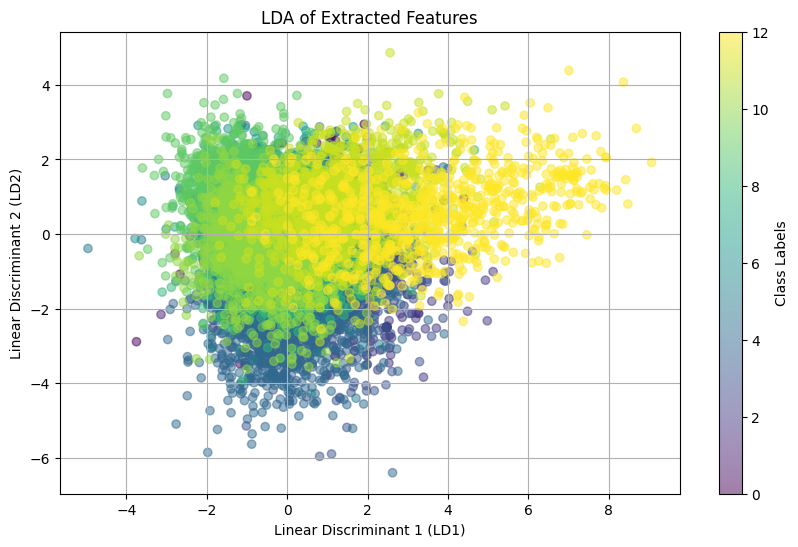

In [28]:
# Visualize LDA Results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(lda_df['LD1'], lda_df['LD2'], c=lda_df['Label'], cmap='viridis', alpha=0.5)
plt.title('LDA of Extracted Features')
plt.xlabel('Linear Discriminant 1 (LD1)')
plt.ylabel('Linear Discriminant 2 (LD2)')
plt.colorbar(scatter, label='Class Labels')
plt.grid()
plt.savefig('lda_2d_visualization.png') 
plt.show()
